<a href="https://colab.research.google.com/github/giteyo/1strepo/blob/main/Hands%20as%20Controllers%3A%20Vision-Based%20Hand%20Tracking%20for%20Physics-Driven%20Game%20Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 0 — Google Colab setup (camera + libraries)
Step 0.1 — Install dependencies (run once)

In [4]:
!pip install mediapipe opencv-python-headless

In [5]:
!pip install mediapipe==0.10.13

In [6]:
import mediapipe as mp

print("MediaPipe version:", mp.__version__)
print("Has solutions:", hasattr(mp, "solutions"))

MediaPipe version: 0.10.13
Has solutions: True


Step 0.2 — Import libraries (Colab style)

In [7]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow

mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

STEP 1 — Webcam capture in Colab

Since Colab cannot directly open your webcam, we use a JavaScript helper.

Step 1.1 — Enable webcam capture

Run this cell exactly as is.

In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo():
    js = Javascript('''
        async function takePhoto() {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getTracks()[0].stop();
          div.remove();

          return canvas.toDataURL('image/jpeg', 0.8);
        }
        ''')
    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])
    return binary


Step 1.2 — Capture one frame and display it

<IPython.core.display.Javascript object>

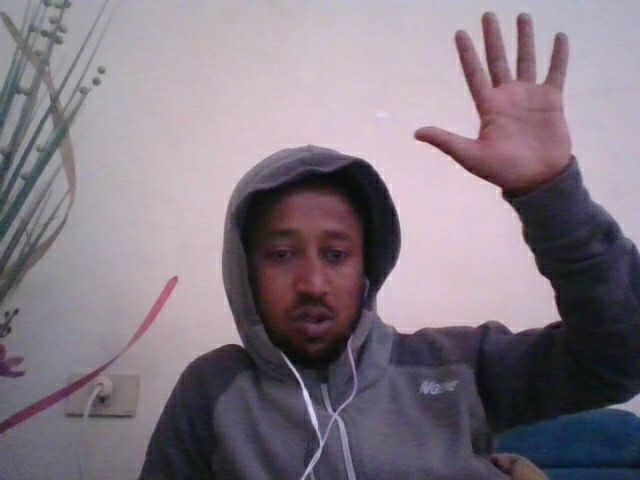

In [15]:
image_bytes = take_photo()

# Convert bytes to OpenCV image
jpg_array = np.frombuffer(image_bytes, dtype=np.uint8)
frame = cv2.imdecode(jpg_array, cv2.IMREAD_COLOR)

cv2_imshow(frame)


STEP 2 — MediaPipe Hands (single frame)

Now we process one frame instead of a live stream.
This is still perfect for learning, feature extraction, and research.

Step 2.1 — Detect and draw hand landmarks

In [25]:
image_bytes = take_photo()

jpg_array = np.frombuffer(image_bytes, dtype=np.uint8)
frame = cv2.imdecode(jpg_array, cv2.IMREAD_COLOR)

<IPython.core.display.Javascript object>

In [26]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

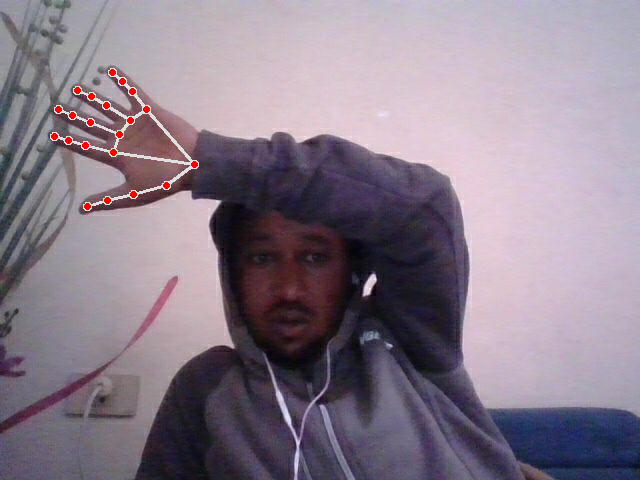

In [27]:
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = hands.process(frame_rgb)

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_draw.draw_landmarks(
            frame,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS
        )

cv2_imshow(frame)
hands.close()

Step 2.2 — Print landmark coordinates (index fingertip)

In [28]:
INDEX_TIP_ID = 8

if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]
    index_tip = hand_landmarks.landmark[INDEX_TIP_ID]

    print(
        f"Index Tip -> x: {index_tip.x:.3f}, "
        f"y: {index_tip.y:.3f}, "
        f"z: {index_tip.z:.3f}"
    )
else:
    print("No hand detected")

Index Tip -> x: 0.085, y: 0.284, z: -0.026


Palm Center (Colab, single frame)
Goal

Compute a single stable point that represents the hand position.

This will later drive movement in the game.

What we define as “palm center”

We’ll average these landmarks:

Wrist (0)

Index MCP (5)

Middle MCP (9)

Ring MCP (13)

Pinky MCP (17)

This is simple, stable, and widely used.

Compute palm center (normalized)

In [29]:
# Palm landmark indices
PALM_IDS = [0, 5, 9, 13, 17]

if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]

    cx = 0
    cy = 0

    for idx in PALM_IDS:
        lm = hand_landmarks.landmark[idx]
        cx += lm.x
        cy += lm.y

    cx /= len(PALM_IDS)
    cy /= len(PALM_IDS)

    print(f"Palm center (normalized): x={cx:.3f}, y={cy:.3f}")
else:
    print("No hand detected")


Palm center (normalized): x=0.220, y=0.283


Draw palm center on the image

Now let’s visualize it.

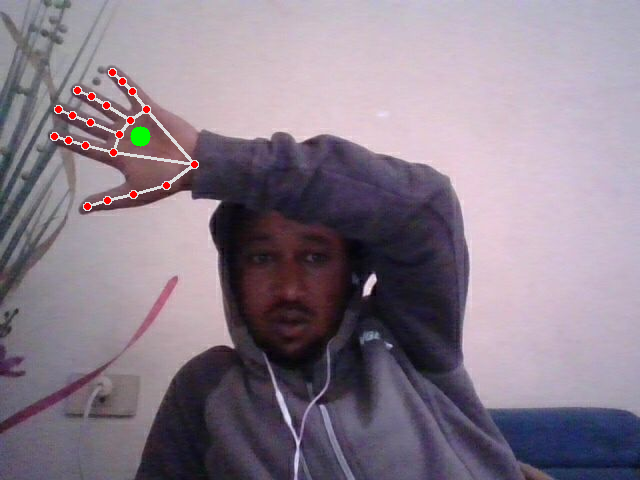

In [30]:
h, w, _ = frame.shape

px = int(cx * w)
py = int(cy * h)

cv2.circle(frame, (px, py), 10, (0, 255, 0), -1)
cv2_imshow(frame)


Important understanding check

At this point, you now have:

Raw landmarks (noisy)

A derived signal (palm center)

A visual confirmation

This palm center will later map to:

Player position

Object control

Camera movement

Everything depends on this being correct.

Hand orientation (2D angle)

Now we compute direction, not just position.

### Compute orientation vector

We use:

Wrist (0)

Middle finger MCP (9)

In [32]:
wrist = hand_landmarks.landmark[0]
middle_mcp = hand_landmarks.landmark[9]

dx = middle_mcp.x - wrist.x
dy = middle_mcp.y - wrist.y


### Convert to angle (degrees)

In [33]:
import math

angle = math.degrees(math.atan2(dy, dx))
print(f"Hand orientation angle: {angle:.2f} degrees")


Hand orientation angle: -151.38 degrees


### Draw orientation arrow

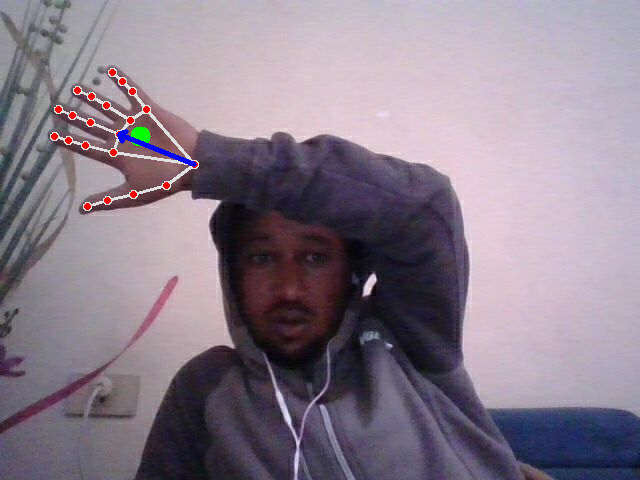

In [34]:
start = (int(wrist.x * w), int(wrist.y * h))
end = (int(middle_mcp.x * w), int(middle_mcp.y * h))

cv2.arrowedLine(frame, start, end, (255, 0, 0), 3)
cv2_imshow(frame)


What you’ve unlocked now

You now have:

Position

Direction

Visual verification

This is enough to:

Control a game object

Measure motion

Analyze jitter

## Velocity & acceleration

### Palm Velocity & Acceleration (Colab-friendly)
#### Core idea (simple)

Position → palm center

Velocity → change in position over time

Acceleration → change in velocity over time

No filtering yet. Raw signal only.

#### Helper: capture + extract palm center

Run this cell once.

In [35]:
import time
import math

PALM_IDS = [0, 5, 9, 13, 17]

def get_palm_center_from_frame(frame, hands):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    if not results.multi_hand_landmarks:
        return None, None

    hand_landmarks = results.multi_hand_landmarks[0]

    cx, cy = 0, 0
    for idx in PALM_IDS:
        lm = hand_landmarks.landmark[idx]
        cx += lm.x
        cy += lm.y

    cx /= len(PALM_IDS)
    cy /= len(PALM_IDS)

    return cx, cy


#### Initialize tracking variables

In [36]:
prev_pos = None
prev_vel = None
prev_time = None


#### Repeated capture loop (manual “real-time”)

Each time you run this cell:

Capture a frame

Compute position

Compute velocity + acceleration

Run this several times, moving your hand slightly between runs.

In [45]:
image_bytes = take_photo()

jpg_array = np.frombuffer(image_bytes, dtype=np.uint8)
frame = cv2.imdecode(jpg_array, cv2.IMREAD_COLOR)

hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

cx, cy = get_palm_center_from_frame(frame, hands)
current_time = time.time()

if cx is None:
    print("No hand detected")
else:
    print(f"Position: x={cx:.3f}, y={cy:.3f}")

    if prev_pos is not None:
        dt = current_time - prev_time

        vx = (cx - prev_pos[0]) / dt
        vy = (cy - prev_pos[1]) / dt
        speed = math.sqrt(vx*vx + vy*vy)

        print(f"Velocity: vx={vx:.3f}, vy={vy:.3f}, speed={speed:.3f}")

        if prev_vel is not None:
            ax = (vx - prev_vel[0]) / dt
            ay = (vy - prev_vel[1]) / dt
            accel = math.sqrt(ax*ax + ay*ay)

            print(f"Acceleration: ax={ax:.3f}, ay={ay:.3f}, mag={accel:.3f}")

        prev_vel = (vx, vy)

    prev_pos = (cx, cy)
    prev_time = current_time

hands.close()


<IPython.core.display.Javascript object>

Position: x=0.155, y=0.693
Velocity: vx=-0.002, vy=0.013, speed=0.013
Acceleration: ax=0.001, ay=-0.001, mag=0.001


What you should observe (important)

Even when your hand is “still”, velocity is not zero

Acceleration spikes randomly

Faster movement = bigger noise spikes

This is the exact motivation for:

EMA filtering

Kalman filtering

Dead zones

You’re now seeing the problem your project is solving.

#### Optional visualization (recommended)

Draw palm center again so you trust the signal:

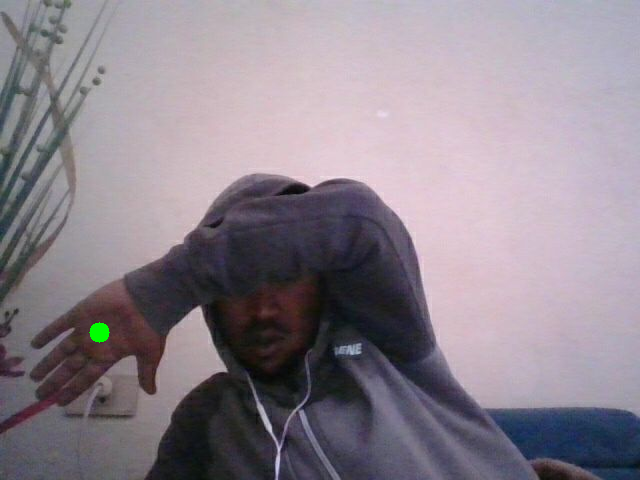

In [46]:
h, w, _ = frame.shape
px, py = int(cx * w), int(cy * h)
cv2.circle(frame, (px, py), 10, (0, 255, 0), -1)
cv2_imshow(frame)


Where we are now (big milestone)

You now have:

Raw position

Velocity

Acceleration

Measurable noise

This is research-grade signal extraction.

#### Gesture states (open vs fist, then pointing)

This will let us:

Trigger actions

Replace keyboard input later

### Gesture Detection (Colab-friendly)
Core idea

A finger is open if:

fingertip is far from the palm

folded if it’s close

We compare finger tip → palm center distance.

#### Landmark IDs we’ll use

In [47]:
# Fingertip landmark IDs
FINGER_TIPS = {
    "thumb": 4,
    "index": 8,
    "middle": 12,
    "ring": 16,
    "pinky": 20
}

PALM_IDS = [0, 5, 9, 13, 17]


#### Compute palm center (reuse logic)

In [48]:
def compute_palm_center(hand_landmarks):
    cx, cy = 0, 0
    for idx in PALM_IDS:
        lm = hand_landmarks.landmark[idx]
        cx += lm.x
        cy += lm.y
    return cx / len(PALM_IDS), cy / len(PALM_IDS)


#### Distance helper

In [49]:
def distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)


#### Detect open vs closed fingers

In [50]:
def detect_finger_states(hand_landmarks):
    palm_x, palm_y = compute_palm_center(hand_landmarks)

    finger_states = {}
    for name, tip_id in FINGER_TIPS.items():
        tip = hand_landmarks.landmark[tip_id]
        d = distance(tip.x, tip.y, palm_x, palm_y)
        finger_states[name] = d

    return finger_states


#### Gesture logic (OPEN vs FIST)

This threshold is intentionally simple.
We’ll tune it later.

In [51]:
def classify_gesture(finger_distances, threshold=0.12):
    open_fingers = sum(d > threshold for d in finger_distances.values())

    if open_fingers >= 4:
        return "OPEN"
    elif open_fingers <= 1:
        return "FIST"
    else:
        return "PARTIAL"


#### Full gesture detection on a captured frame

Run this cell. Move your hand between captures.

<IPython.core.display.Javascript object>

Finger distances:
thumb: 0.049
index: 0.046
middle: 0.023
ring: 0.144
pinky: 0.134

Detected Gesture: PARTIAL


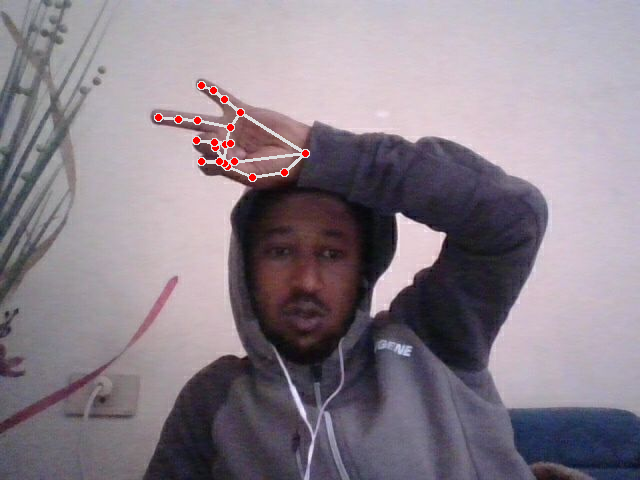

In [60]:
image_bytes = take_photo()
jpg_array = np.frombuffer(image_bytes, dtype=np.uint8)
frame = cv2.imdecode(jpg_array, cv2.IMREAD_COLOR)

hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = hands.process(frame_rgb)

if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]

    finger_distances = detect_finger_states(hand_landmarks)
    gesture = classify_gesture(finger_distances)

    print("Finger distances:")
    for f, d in finger_distances.items():
        print(f"{f}: {d:.3f}")

    print("\nDetected Gesture:", gesture)

    mp_draw.draw_landmarks(
        frame,
        hand_landmarks,
        mp_hands.HAND_CONNECTIONS
    )

else:
    print("No hand detected")

cv2_imshow(frame)
hands.close()


What you should see

Open hand → OPEN

Closed fist → FIST

Mixed fingers → PARTIAL

If classification is slightly off, that’s normal.
We’ll fix this later with:

adaptive thresholds

temporal smoothing

#### Why this matters for your project

You now have:

Continuous signals (position, velocity)

Discrete states (gestures)

This lets you do things like:

OPEN → move object

FIST → grab / stop

Velocity → force

Acceleration → impulse

Exactly what a controller needs.

Big milestone check

At this point, you have completed all of Step 2:

✔ Palm center

✔ Orientation

✔ Velocity & acceleration

✔ Gesture states

This is the entire hand input system.

## STEP 3 — Game Prototype (keyboard-controlled first)

We will:

Build a tiny physics-style game

Keep graphics minimal

Separate game logic from hand input

#### Game idea:

A square moves left/right (player)

A circle falls from top (target)

Player tries to catch the circle


## Setup
```
# This is formatted as code
```



In [62]:
import cv2
import numpy as np

# Game window size
WIDTH, HEIGHT = 640, 480

# Player
player_w, player_h = 60, 20
player_x = WIDTH // 2
player_y = HEIGHT - 50
player_speed = 20

# Falling object
obj_radius = 15
obj_x = np.random.randint(obj_radius, WIDTH-obj_radius)
obj_y = 0
obj_speed = 10

# Key input simulation (we’ll manually change this in Colab)
key = None


## Draw the game state

In [63]:
def draw_game():
    frame = np.ones((HEIGHT, WIDTH, 3), dtype=np.uint8) * 255

    # Draw player
    cv2.rectangle(frame, (player_x, player_y), (player_x + player_w, player_y + player_h), (0, 255, 0), -1)

    # Draw falling object
    cv2.circle(frame, (obj_x, obj_y), obj_radius, (0, 0, 255), -1)

    cv2_imshow(frame)


## Simple game loop (manual “frame advance”)

In Colab, we cannot do real-time keyboard input, so we’ll simulate frames by running the cell repeatedly and changing the key variable.

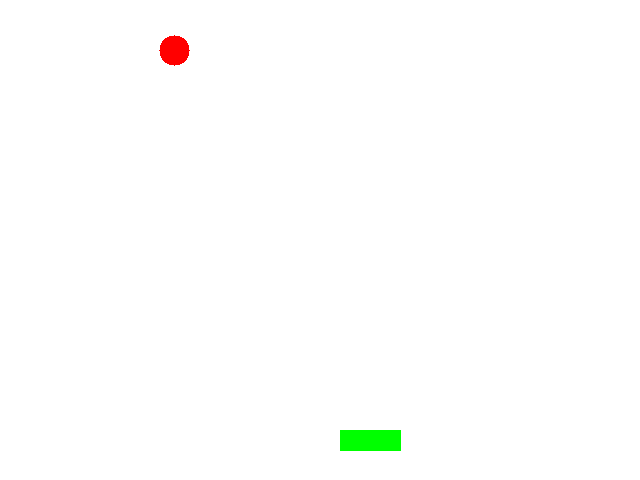

In [68]:
# Simulate key press
# Options: 'left', 'right', None
key = 'left'  # Change manually between runs to test

# Move player
if key == 'left':
    player_x -= player_speed
if key == 'right':
    player_x += player_speed

# Keep player in bounds
player_x = max(0, min(WIDTH - player_w, player_x))

# Move object
obj_y += obj_speed
if obj_y > HEIGHT:
    obj_y = 0
    obj_x = np.random.randint(obj_radius, WIDTH - obj_radius)

draw_game()

## Map Hand to Game Controls (Colab-friendly)
Goal

Palm x → horizontal position of the player

Gesture → action (e.g., OPEN = move right, FIST = move left)

Optional later: velocity → speed

### Capture hand input

We’ll use the functions we already wrote:

In [106]:
image_bytes = take_photo()
jpg_array = np.frombuffer(image_bytes, dtype=np.uint8)
frame = cv2.imdecode(jpg_array, cv2.IMREAD_COLOR)

hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = hands.process(frame_rgb)


<IPython.core.display.Javascript object>

### Compute palm center and gesture

In [107]:
if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]

    # Palm center
    cx, cy = compute_palm_center(hand_landmarks)

    # Gesture
    finger_distances = detect_finger_states(hand_landmarks)
    gesture = classify_gesture(finger_distances)

    print(f"Palm x={cx:.3f}, Gesture={gesture}")
else:
    cx, cy, gesture = None, None, None
    print("No hand detected")


Palm x=0.214, Gesture=OPEN


### Map palm x to player position

In [108]:
if cx is not None:
    player_x = int(cx * (WIDTH - player_w))  # scale normalized x to window


### Map gesture to object action

For example:

In [109]:
if gesture == "OPEN":
    obj_speed = 15
elif gesture == "FIST":
    obj_speed = 5
else:
    obj_speed = 10


### Draw frame

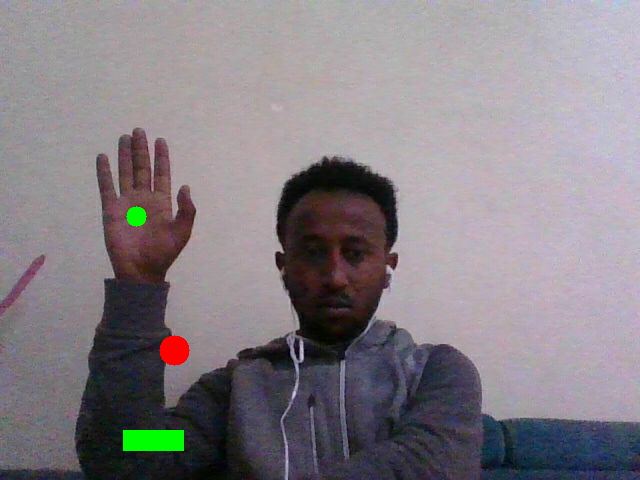

In [110]:
# Move object
obj_y += obj_speed
if obj_y > HEIGHT:
    obj_y = 0
    obj_x = np.random.randint(obj_radius, WIDTH - obj_radius)

# Draw game + hand visualization
px, py = int(cx * WIDTH), int(cy * HEIGHT) if cx else (0, 0)
cv2.circle(frame, (px, py), 10, (0, 255, 0), -1)  # palm center

cv2.rectangle(frame, (player_x, player_y), (player_x + player_w, player_y + player_h), (0, 255, 0), -1)
cv2.circle(frame, (obj_x, obj_y), obj_radius, (0, 0, 255), -1)

cv2_imshow(frame)
# Only close hands if it's still an active object (i.e., not already closed)
if 'hands' in locals() and hands is not None and getattr(hands, '_graph', None) is not None:
    hands.close()


How this works

Move your hand left/right → player moves

Open/Fist → object speed changes

Green dot → palm center

Red circle → falling object

You can now replace any keyboard action with a hand signal.

## STEP 5 — Noise & Latency Handling

We’ll implement three techniques step by step:

EMA smoothing (Exponential Moving Average)

Dead zones (ignore tiny movements)

Optional: Kalman filter (predictive smoothing)

EMA Smoothing for Palm Position

EMA formula:

### Initialize EMA

In [118]:
alpha = 0.3  # smoothing factor
ema_x = None
ema_y = None
prev_ema_x = None
prev_ema_y = None


### Update EMA each frame

In [119]:
if cx is not None:
    if ema_x is None:  # first frame
        ema_x, ema_y = cx, cy
    else:
        # Apply EMA smoothing
        ema_x = alpha * cx + (1 - alpha) * ema_x
        ema_y = alpha * cy + (1 - alpha) * ema_y

    # Dead zone logic
    if prev_ema_x is not None:
        dead_zone = 0.02 # Define dead_zone here for consistent scope
        if abs(ema_x - prev_ema_x) < dead_zone:
            ema_x = prev_ema_x  # ignore tiny change

    # Map smoothed value to player position
    player_x = int(ema_x * (WIDTH - player_w))

    # Update previous EMA for the next frame
    prev_ema_x = ema_x
    prev_ema_y = ema_y


#### Now your player moves smoothly even if your hand jitters slightly.

## Dead Zones

Dead zone prevents tiny hand tremors from moving the player.

In [121]:
# Dead zone logic is now integrated into the EMA update cell.

#### Optional Kalman Filter (advanced)

Kalman filtering predicts your hand position, smoothing even faster movements.

In [122]:
import cv2

# Initialize Kalman filter
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]], np.float32)
kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03


Update for each frame:

In [123]:
if cx is not None:
    measured = np.array([[np.float32(cx*(WIDTH-player_w))],
                         [np.float32(cy*HEIGHT)]])
    predicted = kalman.predict()
    corrected = kalman.correct(measured)

    player_x = int(corrected[0,0])


Kalman is optional but improves high-speed hand movements.

#### Visualize smoothed control

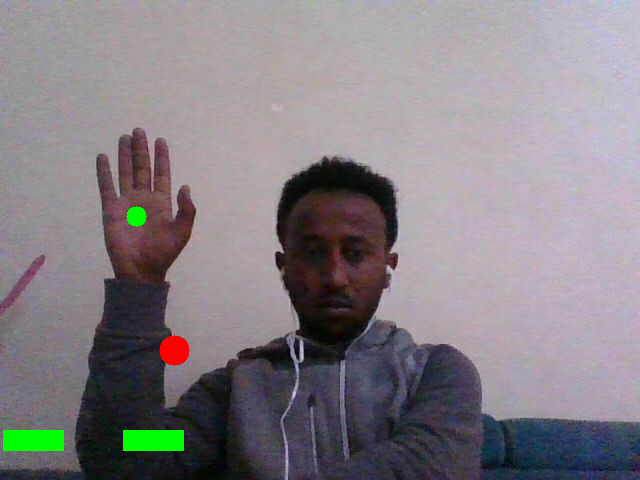

In [124]:
# Draw palm center
px, py = int(ema_x * WIDTH), int(ema_y * HEIGHT)
cv2.circle(frame, (px, py), 10, (0, 255, 0), -1)  # EMA-smoothed green dot

# Player rectangle and object
cv2.rectangle(frame, (player_x, player_y), (player_x + player_w, player_y + player_h), (0, 255, 0), -1)
cv2.circle(frame, (obj_x, obj_y), obj_radius, (0, 0, 255), -1)

cv2_imshow(frame)

Now the player moves smoothly with your hand

Tiny shakes are ignored

Game is playable

#### Step 5 Summary

EMA smoothing → stabilizes position

Dead zones → ignore micro-jitters

Kalman filter → optional, predicts high-speed motion

Your hand is now reliable enough to control a game

## STEP 6 — Visualizing Uncertainty

### Core idea

Palm center confidence → color intensity

Ghost trails → show movement history and jitter

Optional: latency / motion spikes → visual cue

We already have:

cx, cy → raw palm position

ema_x, ema_y → smoothed palm position

prev_pos → previous frame position

We can now measure control uncertainty:

In [125]:
# Uncertainty = distance between raw and smoothed position
uncertainty = 0
if cx is not None:
    uncertainty = math.sqrt((cx - ema_x)**2 + (cy - ema_y)**2)


## Color-coding palm center

Green → low uncertainty (stable)

Yellow/Red → high uncertainty (jittery)

array([[[168, 154, 158],
        [170, 156, 160],
        [176, 159, 163],
        ...,
        [205, 184, 192],
        [205, 187, 194],
        [208, 190, 197]],

       [[166, 152, 156],
        [167, 153, 157],
        [170, 155, 159],
        ...,
        [208, 187, 195],
        [208, 190, 197],
        [211, 193, 200]],

       [[161, 150, 153],
        [164, 150, 154],
        [165, 150, 154],
        ...,
        [213, 192, 200],
        [212, 194, 201],
        [214, 196, 203]],

       ...,

       [[ 59,  27,  32],
        [ 59,  29,  34],
        [ 61,  34,  38],
        ...,
        [ 85,  47,  47],
        [ 90,  51,  53],
        [ 92,  55,  57]],

       [[ 64,  30,  37],
        [ 63,  30,  37],
        [ 64,  33,  40],
        ...,
        [100,  61,  59],
        [ 97,  58,  56],
        [ 88,  50,  50]],

       [[ 64,  30,  37],
        [ 61,  28,  35],
        [ 62,  29,  36],
        ...,
        [101,  60,  57],
        [ 97,  58,  56],
        [ 94,  55,  53]]], dtype=uint8)
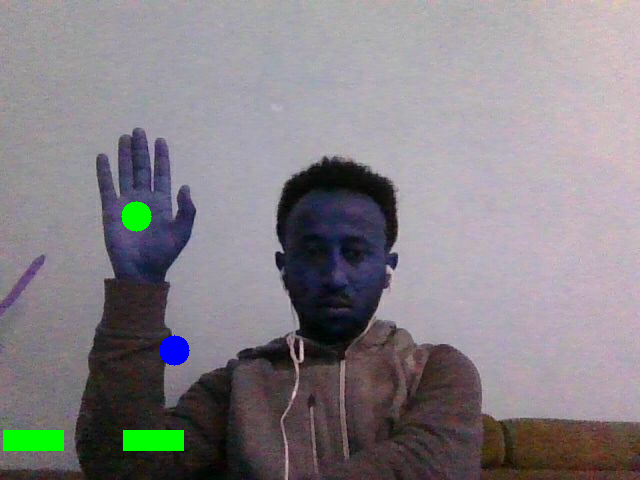

In [126]:
# Map uncertainty to color
# 0.0 → green, 0.05+ → red
uncertainty = min(uncertainty, 0.05)
r = int(255 * (uncertainty / 0.05))
g = int(255 * (1 - uncertainty / 0.05))
b = 0
color = (b, g, r)

px, py = int(ema_x * WIDTH), int(ema_y * HEIGHT)
cv2.circle(frame, (px, py), 15, color, -1)


You’ll now see your palm dot change color based on jitter

## Ghost trail

Keep a small history of positions:

In [127]:
history = []  # store last N frames

if cx is not None:
    history.append((px, py))
    if len(history) > 10:
        history.pop(0)

# Draw trail
for i, (hx, hy) in enumerate(history):
    alpha = int(255 * (i+1) / len(history))
    cv2.circle(frame, (hx, hy), 8, (0, alpha, 255-alpha), -1)


Older positions → fainter

Newer positions → brighter

You can instantly see hand stability.

## Latency / motion spike indicator

In [128]:
if prev_pos is not None:
    motion = math.sqrt((px - prev_pos[0])**2 + (py - prev_pos[1])**2)
    if motion > 15:  # arbitrary spike threshold
        cv2.putText(frame, "HIGH LATENCY / SPIKE!", (10,50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)


## Draw game + uncertainty visualization

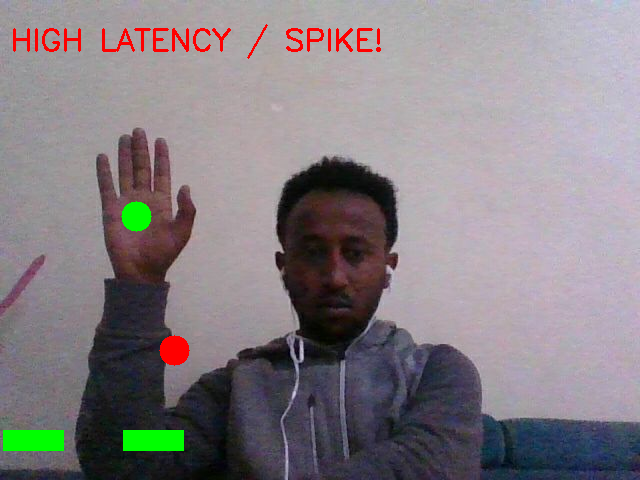

In [129]:
# Player rectangle
cv2.rectangle(frame, (player_x, player_y), (player_x + player_w, player_y + player_h), (0, 255, 0), -1)
# Falling object
cv2.circle(frame, (obj_x, obj_y), obj_radius, (0, 0, 255), -1)

cv2_imshow(frame)


Now you can see exactly when your hand control is unstable
✅ Ghost trail shows smoothness
✅ Color shows jitter
✅ Optional warning for big spikes

Perfect! Let’s combine everything into a single, Colab-friendly “frame-by-frame loop” so you can play the game, see gestures, smoothing, ghost trails, and uncertainty all at once.

Remember: in Colab we cannot do real-time streaming, so we’ll run the cell multiple times, each time capturing a new frame. It behaves like a “step-by-step live game.”

## STEP 7 — Full Hand-Controlled Game Loop (Colab)

## Initialize global variables

In [130]:
# Game settings
WIDTH, HEIGHT = 640, 480
player_w, player_h = 60, 20
player_x = WIDTH // 2
player_y = HEIGHT - 50
obj_radius = 15
obj_x = np.random.randint(obj_radius, WIDTH-obj_radius)
obj_y = 0
obj_speed = 10

# Smoothing & control
alpha = 0.3  # EMA factor
ema_x, ema_y = None, None
prev_ema_x = None
history = []

# Hand tracking
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)


## Full capture + game update

Run this cell each time you want to “advance a frame”:

<IPython.core.display.Javascript object>

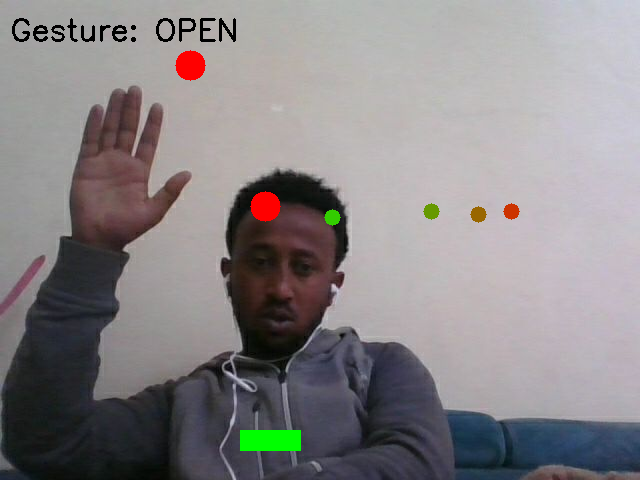

In [135]:
import math
import numpy as np
from google.colab.patches import cv2_imshow

# --- Capture frame ---
image_bytes = take_photo()
jpg_array = np.frombuffer(image_bytes, dtype=np.uint8)
frame = cv2.imdecode(jpg_array, cv2.IMREAD_COLOR)

# --- Hand detection ---
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = hands.process(frame_rgb)

if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]

    # Palm center
    cx, cy = compute_palm_center(hand_landmarks)

    # EMA smoothing
    if ema_x is None:
        ema_x, ema_y = cx, cy
    else:
        ema_x = alpha * cx + (1 - alpha) * ema_x
        ema_y = alpha * cy + (1 - alpha) * ema_y

    # Dead zone
    dead_zone = 0.02
    if prev_ema_x is not None and abs(ema_x - prev_ema_x) < dead_zone:
        ema_x = prev_ema_x

    prev_ema_x = ema_x

    # Gesture
    finger_distances = detect_finger_states(hand_landmarks)
    gesture = classify_gesture(finger_distances)

    # Map palm x to player
    player_x = int(ema_x * (WIDTH - player_w))

    # Map gesture to object speed
    if gesture == "OPEN":
        obj_speed = 15
    elif gesture == "FIST":
        obj_speed = 5
    else:
        obj_speed = 10

    # Uncertainty visualization
    uncertainty = min(math.sqrt((cx - ema_x)**2 + (cy - ema_y)**2), 0.05)
    r = int(255 * (uncertainty / 0.05))
    g = int(255 * (1 - uncertainty / 0.05))
    b = 0
    color = (b, g, r)

    px, py = int(ema_x * WIDTH), int(ema_y * HEIGHT)
    history.append((px, py))
    if len(history) > 10:
        history.pop(0)

else:
    # No hand detected
    px, py = 0, 0
    gesture = "NONE"

# --- Move object ---
obj_y += obj_speed
if obj_y > HEIGHT:
    obj_y = 0
    obj_x = np.random.randint(obj_radius, WIDTH - obj_radius)

# --- Draw ghost trail ---
for i, (hx, hy) in enumerate(history):
    alpha_trail = int(255 * (i+1) / len(history))
    cv2.circle(frame, (hx, hy), 8, (0, alpha_trail, 255-alpha_trail), -1)

# --- Draw palm center ---
cv2.circle(frame, (px, py), 15, color, -1)

# --- Draw player & object ---
cv2.rectangle(frame, (player_x, player_y), (player_x + player_w, player_y + player_h), (0, 255, 0), -1)
cv2.circle(frame, (obj_x, obj_y), obj_radius, (0, 0, 255), -1)

# --- Display gesture on screen ---
cv2.putText(frame, f"Gesture: {gesture}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

cv2_imshow(frame)
